# **PRIDNet — Pyramid Real Image Denoising Network**
- While deep Convolutional Neural Networks (CNNs) have shown extraordinary capability of modelling specific noise and denoising, they still perform poorly on real-world noisy images. The main reason is that the real-world noise is more sophisticated and diverse. To tackle the issue of blind denoising, in this paper, we propose a novel pyramid real image denoising network (PRIDNet), which contains three stages. First, the noise estimation stage uses channel attention mechanism to recalibrate the channel importance of input noise. Second, at the multi-scale denoising stage, pyramid pooling is utilized to extract multi-scale features. Third, the stage of feature fusion adopts a kernel selecting operation to adaptively fuse multi-scale features. Experiments on two datasets of real noisy photographs demonstrate that our approach can achieve competitive performance in comparison with state-of-the-art denoisers in terms of both quantitative measure and visual perception quality.


Network Architecture:
<br>

<img src ="https://storage.googleapis.com/groundai-web-prod/media%2Fusers%2Fuser_282201%2Fproject_384731%2Fimages%2Fx1.png" >

[Github](https://github.com/491506870/PRIDNet)<br>
[Paper](https://arxiv.org/abs/1908.00273?context=cs.CV)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import pathlib
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import cv2
import skimage
from skimage.util import random_noise
import tensorflow as tf

from tqdm.notebook import tqdm
import random

In [ ]:
# Download files from Google drive using sharable link,
# https://stackoverflow.com/a/50670037/7697658
if 'NIND' not in os.listdir():
    !gdown https://drive.google.com/uc?id=1t5c3OUmHHDDvtpz4O-Gu_qrgggPxBAUW
    get_ipython().system_raw('7z x NIND.zip -o/content/ && rm NIND.zip')

Downloading...
From: https://drive.google.com/uc?id=1t5c3OUmHHDDvtpz4O-Gu_qrgggPxBAUW
To: /content/NIND.zip
3.22GB [00:32, 98.4MB/s]


In [3]:
# Download files from Google drive using sharable link,
# https://stackoverflow.com/a/50670037/7697658
if 'Mi3_Aligned' not in os.listdir():
    !gdown https://drive.google.com/uc?id=1MrcCSnM3Weu7Wi-n0iNBxfFYlHy0ZUpX
    get_ipython().system_raw('7z x Mi3_Aligned.zip -o/content/ && rm Mi3_Aligned.zip')

Downloading...
From: https://drive.google.com/uc?id=1MrcCSnM3Weu7Wi-n0iNBxfFYlHy0ZUpX
To: /content/Mi3_Aligned.zip
2.71GB [00:36, 73.7MB/s]


In [4]:
# Extract zip files to a destination directory,
# https://askubuntu.com/a/1049564
if 'SIDD_Small_sRGB_Only' not in os.listdir():
    !gdown https://drive.google.com/uc?id=1uhBXtYT2BZEbHEShTBw4KKOjj3SUnHrD
    get_ipython().system_raw('7z x SIDD_Small_sRGB_Only.zip -o/content/ && rm SIDD_Small_sRGB_Only.zip')

Downloading...
From: https://drive.google.com/uc?id=1uhBXtYT2BZEbHEShTBw4KKOjj3SUnHrD
To: /content/SIDD_Small_sRGB_Only.zip
6.62GB [02:13, 49.4MB/s]


In [5]:
def get_images_paths(root_dir_ssid, root_dir_mi, root_dir_nind):
    # Getting SSID dataset images
    root = pathlib.Path(root_dir_ssid)
    img_paths = list(root.rglob("*.PNG*"))
    img_paths_lst = [str(path) for path in img_paths]

    gt_lst = []
    noisy_lst= []
    for p in img_paths_lst:
        img_type = p.split("/")[-1].split('_')[-3]
        if img_type=="NOISY":
            noisy_lst.append(p)
        elif img_type=="GT":
            gt_lst.append(p)

    # Getting mi dataset images
    root = pathlib.Path(root_dir_mi)
    img_paths = list(root.rglob("*.bmp*"))
    img_paths_lst = [str(path) for path in img_paths]

    for p in img_paths_lst:
        img_type = p.split("/")[-1].split('_')[-1]
        if "Noisy" in img_type:
            noisy_lst.append(p)
        elif "Reference" in img_type:
            gt_lst.append(p)
            gt_lst.append(p)


    # Getting NIND dataset images
    root = pathlib.Path(root_dir_nind)
    img_paths = list(root.rglob("*.png*"))
    img_paths.extend(list(root.rglob("*.jpg*")))
    img_paths_lst = [str(path) for path in img_paths]

    for p in img_paths_lst:
        img_type = p.split("/")[-1].split("_")[-1]
        if "H" in img_type:
            noisy_lst.append(p)
        else:
            gt_lst.append(p)

    noisy_array = np.asarray(noisy_lst)
    gt_array = np.asarray(gt_lst)
    return noisy_array, gt_array

In [6]:
from sklearn.model_selection import train_test_split
noisy_array_paths, gt_array_paths = get_images_paths("SIDD_Small_sRGB_Only", "Mi3_Aligned", "NIND")
noisy_train_paths, noisy_test_paths, gt_train_paths, gt_test_paths = train_test_split(noisy_array_paths, gt_array_paths, test_size=0.20, random_state=42)

In [7]:
print(noisy_train_paths.shape)
print(noisy_test_paths.shape)
print(gt_train_paths.shape)
print(gt_test_paths.shape)

(192,)
(48,)
(192,)
(48,)


In [9]:
# Get gt_images in memory
def get_images_in_mem(images_paths):
    images_lst = []
    for img_path in tqdm(images_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        images_lst.append(img)
    return np.array(images_lst)

In [10]:
noisy_train_images = get_images_in_mem(noisy_train_paths)
noisy_test_images = get_images_in_mem(noisy_test_paths)

gt_train_images = get_images_in_mem(gt_train_paths)
gt_test_images = get_images_in_mem(gt_test_paths)

print(noisy_train_images.shape)
print(noisy_test_images.shape)

print(gt_train_images.shape)
print(gt_test_images.shape)


(192, 256, 256, 3)
(48, 256, 256, 3)
(192, 256, 256, 3)
(48, 256, 256, 3)


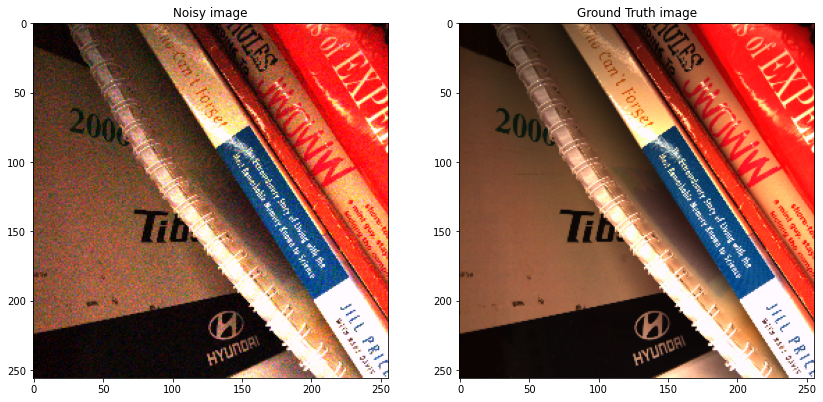

In [11]:
f, axarr = plt.subplots(1,2, figsize=(14,14))
axarr[0].imshow(noisy_train_images[5])
axarr[0].set_title("Noisy image")
axarr[1].imshow(gt_train_images[5])
axarr[1].title.set_text("Ground Truth image")

In [12]:
def _up_down_flip(image, label):
    image = tf.image.flip_up_down(image)
    label = tf.image.flip_up_down(label)
    return image, label

def _left_right_flip(image, label):
    image = tf.image.flip_left_right(image)
    label = tf.image.flip_left_right(label)
    return image, label

def _rotate(image, label):
    random_angle = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, random_angle)
    label = tf.image.rot90(label, random_angle)
    return image, label

def _hue(image, label):
    rand_value = random.uniform(-1,1)
    image = tf.image.adjust_hue(image, rand_value)
    label = tf.image.adjust_hue(label, rand_value)
    return image, label

def _brightness(image, label):
    rand_value = random.uniform(-0.08,0.25)
    image = tf.image.adjust_brightness(image, rand_value)
    label = tf.image.adjust_brightness(label, rand_value)
    return image, label

def _saturation(image, label):
    rand_value = random.uniform(1, 5)
    image = tf.image.adjust_saturation(image, rand_value)
    label = tf.image.adjust_saturation(label, rand_value)
    return image, label

def _contrast(image, label):
    rand_value = random.uniform(1, 3)
    image = tf.image.adjust_contrast(image, rand_value)
    label = tf.image.adjust_contrast(label, rand_value)
    return image, label

# What does batch, repeat, and shuffle do with TensorFlow Dataset?
# https://stackoverflow.com/q/53514495/7697658
def tf_data_generator(X, y, batch_size=32, augmentations=None):
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) # This is the main step for data generation
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)

    if augmentations:
        for f in augmentations:
            if np.random.uniform(0,1)<0.5:
                dataset = dataset.map(f, num_parallel_calls=2)

    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

BATCH_SIZE = 4
# augmentation_lst = [_up_down_flip, _left_right_flip, _rotate, _hue, _brightness, _saturation, _contrast]
augmentation_lst = [_up_down_flip, _left_right_flip, _rotate]
image_generator_train = tf_data_generator(X=noisy_train_images, y=gt_train_images, batch_size=BATCH_SIZE, augmentations=augmentation_lst)
image_generator_test = tf_data_generator(X=noisy_test_images, y=gt_test_images, batch_size=BATCH_SIZE)

In [13]:
image_generator_train

<PrefetchDataset shapes: ((4, 256, 256, 3), (4, 256, 256, 3)), types: (tf.uint8, tf.uint8)>

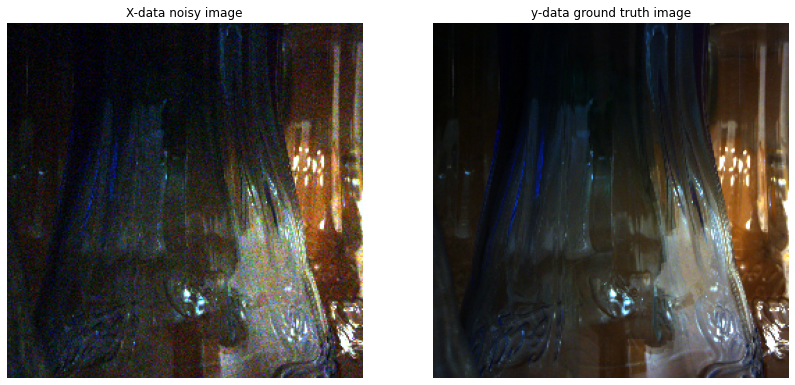

In [14]:
# SANITY CHECK of the Dataset generator
for noisy, gt in image_generator_train.take(1):  # only take first element of dataset
    numpy_images = noisy.numpy()
    numpy_labels = gt.numpy()

f, axarr = plt.subplots(1,2, figsize=(14,14))
axarr[0].imshow(numpy_images[1])
axarr[0].set_title("X-data noisy image")
axarr[0].set_axis_off()

axarr[1].imshow(numpy_labels[1])
axarr[1].set_title("y-data ground truth image")
axarr[1].set_axis_off()

**PRIDNet**

In [15]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,\
                                    GlobalAveragePooling2D, AveragePooling2D, MaxPool2D, UpSampling2D,\
                                    BatchNormalization, Activation, Flatten, Dense, Input,\
                                    Add, Multiply, Concatenate, concatenate, Softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax

tf.keras.backend.set_image_data_format('channels_last')

In [16]:
class Convolutional_block(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_2 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_3 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_4 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')

    def call(self, X):
        X_1 = self.conv_1(X)
        X_1 = Activation('relu')(X_1)

        X_2 = self.conv_2(X_1)
        X_2 = Activation('relu')(X_2)

        X_3 = self.conv_3(X_2)
        X_3 = Activation('relu')(X_3)

        X_4 = self.conv_4(X_3)
        X_4 = Activation('relu')(X_4)
        
        #print('---conv block=',X_4.shape)
        
        return X_4

In [17]:
class Channel_attention(tf.keras.layers.Layer):
    def __init__(self, C=64, **kwargs):
        super().__init__(**kwargs)
        self.C=C
        self.gap = GlobalAveragePooling2D()
        self.dense_middle = Dense(units=2, activation='relu')
        self.dense_sigmoid = Dense(units=self.C, activation='sigmoid')
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'C': self.C
        })
        return config

    def call(self, X):
        v = self.gap(X)
        #print("ca_ after gap =",v.shape)
        fc1 = self.dense_middle(v)
        #print("ca_ after fc1 =",fc1.shape)
        mu = self.dense_sigmoid(fc1)
        #print("ca_ after fc2 =",mu.shape)

        U_out = Multiply()([X, mu])
        
        #print('---channel attention block=',U_out.shape)

        return U_out

In [18]:
class Avg_pool_Unet_Upsample_msfe(tf.keras.layers.Layer):
    def __init__(self, avg_pool_size, upsample_rate, **kwargs):
        super().__init__(**kwargs)
        # ---initialization for Avg pooling---
        self.avg_pool = AveragePooling2D(pool_size=avg_pool_size, padding='same')

        # --- initialization for Unet---
        self.deconv_lst = []
        filter=512
        for i in range(4):
            self.deconv_lst.append(Conv2DTranspose(filters=filter/2, kernel_size=[3, 3], strides=2, padding='same'))
            filter/=2

        self.conv_32_down_lst = []
        for i in range(4):
            self.conv_32_down_lst.append(Conv2D(filters=64, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_64_down_lst = []
        for i in range(4):
            self.conv_64_down_lst.append(Conv2D(filters=128, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_128_down_lst = []
        for i in range(4):
            self.conv_128_down_lst.append(Conv2D(filters=256, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_256_down_lst = []
        for i in range(4):
            self.conv_256_down_lst.append(Conv2D(filters=512, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_512_down_lst = []
        for i in range(4):
            self.conv_512_down_lst.append(Conv2D(filters=1024, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))


        self.conv_32_up_lst = []
        for i in range(3):
            self.conv_32_up_lst.append(Conv2D(filters=64, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_64_up_lst = []
        for i in range(3):
            self.conv_64_up_lst.append(Conv2D(filters=128, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_128_up_lst = []
        for i in range(3):
            self.conv_128_up_lst.append(Conv2D(filters=256, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_256_up_lst = []
        for i in range(3):
            self.conv_256_up_lst.append(Conv2D(filters=512, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))


        self.conv_3 = Conv2D(filters=3, kernel_size=[1, 1])

        self.pooling1_unet = MaxPool2D(pool_size=[2, 2], padding='same')
        self.pooling2_unet = MaxPool2D(pool_size=[2, 2], padding='same')
        self.pooling3_unet = MaxPool2D(pool_size=[2, 2], padding='same')
        self.pooling4_unet = MaxPool2D(pool_size=[2, 2], padding='same')

        # ---initialization for Upsampling---
        self.upsample = UpSampling2D(upsample_rate, interpolation='bilinear')
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'avg_pool_size': self.avg_pool_size,
            'upsample_rate':self.upsample_rate
        })
        return config

    def upsample_and_concat(self, x1, x2, i):
        deconv = self.deconv_lst[i](x1)
        deconv_output = Concatenate()([deconv, x2])
        return deconv_output

    def unet(self, input):
        # ---Unet downsampling---
        conv1 = input
        for c_32 in self.conv_32_down_lst:
            conv1 = c_32(conv1)
        pool1 = self.pooling1_unet(conv1)

        conv2 = pool1
        for c_64 in self.conv_64_down_lst:
            conv2 = c_64(conv2)
        pool2 = self.pooling2_unet(conv2)

        conv3 = pool2
        for c_128 in self.conv_128_down_lst:
            conv3 = c_128(conv3)
        pool3 = self.pooling3_unet(conv3)

        conv4 = pool3
        for c_256 in self.conv_256_down_lst:
            conv4 = c_256(conv4)
        pool4 = self.pooling4_unet(conv4)

        conv5 = pool4
        for c_512 in self.conv_512_down_lst:
            conv5 = c_512(conv5)

        # ---Unet upsampling---
        up6 = self.upsample_and_concat(conv5, conv4, 0)
        conv6 = up6
        for c_256 in self.conv_256_up_lst:
            conv6 = c_256(conv6)

        up7 = self.upsample_and_concat(conv6, conv3, 1)
        conv7 = up7
        for c_128 in self.conv_128_up_lst:
            conv7 = c_128(conv7)

        up8 = self.upsample_and_concat(conv7, conv2, 2)
        conv8 = up8
        for c_64 in self.conv_64_up_lst:
            conv8 = c_64(conv8)

        up9 = self.upsample_and_concat(conv8, conv1, 3)
        conv9 = up9
        for c_32 in self.conv_32_up_lst:
            conv9 = c_32(conv9)

        conv10 = self.conv_3(conv9)
        return conv10

    def call(self, X):
        avg_pool = self.avg_pool(X)
        #print("ap =",avg_pool.shape)
        unet = self.unet(avg_pool)
        upsample = self.upsample(unet)
        return upsample

In [19]:
class Multi_scale_feature_extraction(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.msfe_16 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=16, upsample_rate=16)
        self.msfe_8 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=8, upsample_rate=8)
        self.msfe_4 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=4, upsample_rate=4)
        self.msfe_2 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=2, upsample_rate=2)
        self.msfe_1 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=1, upsample_rate=1)

    def call(self, X):
        up_sample_16 = self.msfe_16(X)
        up_sample_8 = self.msfe_8(X)
        up_sample_4 = self.msfe_4(X)
        up_sample_2 = self.msfe_2(X)
        up_sample_1 = self.msfe_1(X)
        msfe_out = Concatenate()([X, up_sample_16, up_sample_8, up_sample_4, up_sample_2, up_sample_1])

        #print('---Multi scale feature extraction block=',msfe_out.shape)
        return msfe_out

In [20]:
class Kernel_selecting_module(tf.keras.layers.Layer):
    def __init__(self, C=21, **kwargs):
        super().__init__(**kwargs)
        self.C = C
        self.c_3 = Conv2D(filters=self.C, kernel_size=(3,3), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.c_5 = Conv2D(filters=self.C, kernel_size=(5,5), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.c_7 = Conv2D(filters=self.C, kernel_size=(7,7), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.gap = GlobalAveragePooling2D()
        self.dense_two = Dense(units=2, activation='relu')
        self.dense_c1 = Dense(units=self.C)
        self.dense_c2 = Dense(units=self.C)
        self.dense_c3 = Dense(units=self.C)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'C': self.C
        })
        return config

    def call(self, X):
        X_1 = self.c_3(X)
        X_2 = self.c_5(X)
        X_3 = self.c_7(X)

        X_dash = Add()([X_1, X_2, X_3])

        v_gap = self.gap(X_dash)
        v_gap = tf.reshape(v_gap, [-1, 1, 1, self.C])
        fc1 = self.dense_two(v_gap)

        alpha = self.dense_c1(fc1)
        beta = self.dense_c2(fc1)
        gamma = self.dense_c3(fc1)

        before_softmax = concatenate([alpha, beta, gamma], 1)
        # print(before_softmax.shape)
        after_softmax = softmax(before_softmax, axis=1)
        a1 = after_softmax[:, 0, :, :]
        # print(a1)
        a1 = tf.reshape(a1, [-1, 1, 1, self.C])
        # print(a1)
        a2 = after_softmax[:, 1, :, :]
        a2 = tf.reshape(a2, [-1, 1, 1, self.C])
        a3 = after_softmax[:, 2, :, :]
        a3 = tf.reshape(a3, [-1, 1, 1, self.C])

        select_1 = Multiply()([X_1, a1])
        select_2 = Multiply()([X_2, a2])
        select_3 = Multiply()([X_3, a3])

        out = Add()([select_1, select_2, select_3])

        return out

In [21]:
def create_model():
    # ca_block = Channel Attention block
    # msfe_block = Multi scale feature extraction block
    # ksm = Kernel Selecting Module
    tf.keras.backend.clear_session()

    input = Input(shape=(256,256,3), name="input_layer")
    print("Input =",input.shape)

    conv_block = Convolutional_block()(input)
    print("Conv block =",conv_block.shape)
    ca_block = Channel_attention()(conv_block)
    print("Channel Attention =",ca_block.shape)
    ca_block = Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same')(ca_block)
    print("Channel Attention Last CNN =",ca_block.shape)
    ca_block = Concatenate()([input, ca_block])
    print("First phase =",ca_block.shape)
    print()

    msfe_block = Multi_scale_feature_extraction()(ca_block)

    print("Multi-scale feature extraction =",msfe_block.shape)

    ksm = Kernel_selecting_module()(msfe_block)
    ksm = Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same')(ksm)
    print("Kernel Selection Module =",ksm.shape)
    model = Model(inputs=[input], outputs=[ksm])
    return model

model = create_model()
model.summary()

Input = (None, 256, 256, 3)
Conv block = (None, 256, 256, 64)
Channel Attention = (None, 256, 256, 64)
Channel Attention Last CNN = (None, 256, 256, 3)
First phase = (None, 256, 256, 6)

Multi-scale feature extraction = (None, 256, 256, 21)
Kernel Selection Module = (None, 256, 256, 3)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
convolutional_block (Convolutio (None, 256, 256, 64) 112576      input_layer[0][0]                
__________________________________________________________________________________________________
channel_attention (Channel_atte (None, 256, 256, 64) 322         convolutional_block[0][0]        
_____

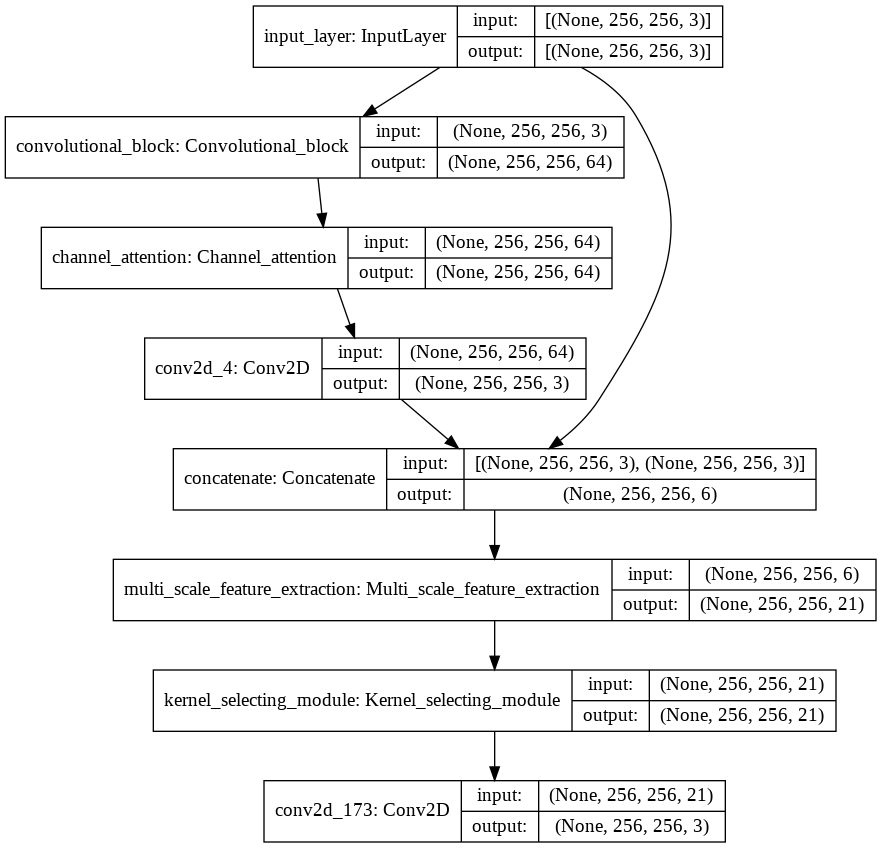

In [22]:
tf.keras.utils.plot_model(model=model, to_file='model_plot.png', show_shapes=True)

In [23]:
steps_per_epoch_train = len(noisy_train_images)
steps_per_epoch_validation = len(noisy_test_images)

In [24]:
best_models_path = "/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/Best Models/PRIDNet model/"
callbacks_lst = [
                 tf.keras.callbacks.ModelCheckpoint(filepath=best_models_path+"best_PRIDNet_blindnoise_256x256.h5", period=10, save_weights_only=False),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.0000009, min_delta=0.0001, factor=0.70, patience=3, verbose=1, mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.0001, patience=10)
]

In [25]:

model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.0009))
model.fit(image_generator_train, 
          validation_data=image_generator_test,
                        steps_per_epoch=steps_per_epoch_train,
                        validation_steps=steps_per_epoch_validation,
                        epochs=10,
                        verbose=1,
                        callbacks=callbacks_lst)

Epoch 1/10
192/192 [==============================] - 195s 877ms/step - loss: 34544087513.7019 - val_loss: 516.7750
Epoch 2/10
192/192 [==============================] - 174s 907ms/step - loss: 480.1131 - val_loss: 344.9249
Epoch 3/10
192/192 [==============================] - 175s 914ms/step - loss: 440.0652 - val_loss: 378.2716
Epoch 4/10
192/192 [==============================] - 175s 913ms/step - loss: 357.3413 - val_loss: 264.7757
Epoch 5/10
192/192 [==============================] - 175s 914ms/step - loss: 254.7474 - val_loss: 235.6037
Epoch 6/10
192/192 [==============================] - 176s 915ms/step - loss: 226.6004 - val_loss: 198.2443
Epoch 7/10
192/192 [==============================] - 176s 914ms/step - loss: 198.0477 - val_loss: 188.6547
Epoch 8/10
192/192 [==============================] - 175s 914ms/step - loss: 185.9921 - val_loss: 175.6310
Epoch 9/10
192/192 [==============================] - 176s 915ms/step - loss: 177.5486 - val_loss: 157.4432
Epoch 10/10
192/192 

In [26]:
# Inference
def inference_single_image(model, noisy_image):
    input_image = np.expand_dims(noisy_image, axis=0)
    predicted_image = model.predict(input_image)
    
    return predicted_image[0]

In [27]:
def inference_batch_images(model, noisy_images):
    predicted_image = model.predict(noisy_images)
    return predicted_image

In [28]:
def visualize_predictions(model, X_test, y_test, n):
    random_numbers = random.choices(range(X_test.shape[0]), k=n)    # Get n random indices
    for i in random_numbers:
        noisy_image = X_test[i]
        gt_image = y_test[i]
        predicted_image = inference_single_image(model, X_test[i])
        predicted_image/=255

        f, axarr = plt.subplots(1,3, figsize=(21,21))
        axarr[0].imshow(noisy_image)
        axarr[0].set_title("Noisy image")
        axarr[0].set_axis_off()
        axarr[1].imshow(gt_image)
        axarr[1].set_title("Ground truth image")
        axarr[1].set_axis_off()
        axarr[2].imshow(predicted_image)
        axarr[2].set_title("Predicted image")
        axarr[2].set_axis_off()

In [29]:
best_models_path = "/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/Best Models/PRIDNet model/"
model = tf.keras.models.load_model(best_models_path+'best_PRIDNet_blindnoise_256x256.h5', custom_objects={'Convolutional_block': Convolutional_block,
                                                                                                        'Channel_attention':Channel_attention,
                                                                                                        'Avg_pool_Unet_Upsample_msfe':Avg_pool_Unet_Upsample_msfe,
                                                                                                        'Multi_scale_feature_extraction':Multi_scale_feature_extraction,
                                                                                                        'Kernel_selecting_module':Kernel_selecting_module})

In [31]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images.shape[0]
psnr_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

Original average gt-noisy PSNR -> 27.89533182146907
Predicted average gt-predicted PSNR -> 28.99740662166197


In [32]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images.shape[0]
ssim_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

Original average gt-noisy SSIM -> 0.614574545423615
Predicted average gt-predicted SSIM -> 0.7167911081744464
